In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
# Loading data
vuaa = pd.read_csv('VUAA.DE.csv', usecols=['Date', 'Close'], parse_dates = ['Date'], index_col = 'Date')
meud = pd.read_excel('Amundi Stoxx Europe 600 UCITS ETF Acc.xlsx', 
                             usecols = ['Datum', 'Offizieller Nettoinventarwert (NAV)'],
                            parse_dates = ['Datum'], index_col = 'Datum')

print('************** American Market S&P500 **************')
vuaa.info()

print('************** European Market Stoxx600 **************')
meud.info()


************** American Market S&P500 **************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1123 entries, 2020-02-04 to 2024-06-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1123 non-null   float64
dtypes: float64(1)
memory usage: 17.5 KB
************** European Market Stoxx600 **************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2863 entries, 2024-06-26 to 2013-04-03
Data columns (total 1 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Offizieller Nettoinventarwert (NAV)  2863 non-null   float64
dtypes: float64(1)
memory usage: 44.7 KB


In [3]:
# Column name change prior concatenation
vuaa.rename(columns = {'Close' : 'VUAA'}, inplace = True)
meud.rename(columns={'Offizieller Nettoinventarwert (NAV)' : 'MEUD'}, inplace = True)

In [4]:
etfs_hist_returns = pd.concat([vuaa, meud], axis = 1)
print(etfs_hist_returns.head())

print('********************* Missing Values *********************')
print(etfs_hist_returns.isna().sum()) # Stoxx600 contains a single missing value

            VUAA    MEUD
2013-04-03   NaN  100.00
2013-04-04   NaN   98.98
2013-04-05   NaN   97.48
2013-04-08   NaN   97.69
2013-04-09   NaN   97.82
********************* Missing Values *********************
VUAA    1741
MEUD       1
dtype: int64


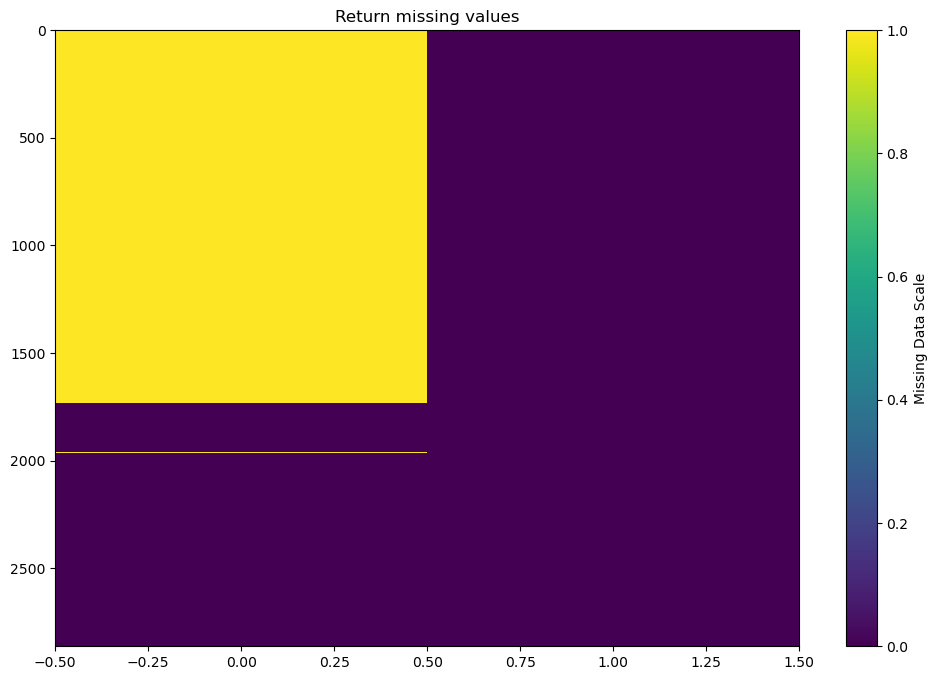

In [5]:
# Visualization of missing values
plt.figure(figsize=(12, 8))
plt.imshow(etfs_hist_returns.isna(), aspect='auto', interpolation='none')
plt.colorbar(label='Missing Data Scale')
plt.title('Return missing values')
plt.show()

<Figure size 1200x800 with 0 Axes>

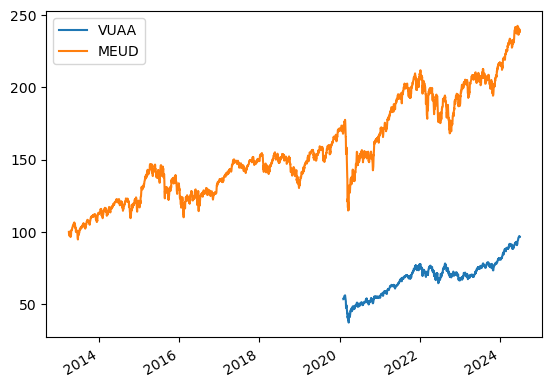

In [6]:
plt.figure(figsize=(12, 8))
etfs_hist_returns.plot()
plt.show()

In [7]:
# Discarding missing dates
etfs_hist_returns = etfs_hist_returns.dropna(axis = 0)

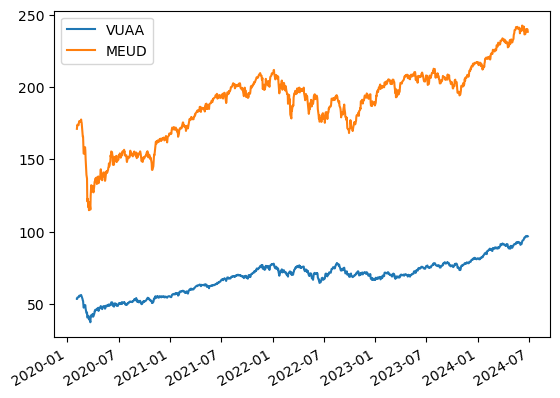

In [8]:
# Plot equally-dated daily returns
etfs_hist_returns.plot()
plt.show()

## Bechmark Asset Allocation: 75% VUAA and 25% MEU

In [9]:
# Current investment strategy
ben_weights = np.array([0.75, 0.25])
rfr = 0.026
months = etfs_hist_returns.index.to_period('M').nunique() # more accurate time-period representation
target_return_daily = (1 + rfr)**(1/365) - 1 # conversion of annual rfr to daily interest

# Portfolio daily returns
daily_return = etfs_hist_returns.pct_change().dropna()
port_daily_return = daily_return.dot(ben_weights)

# Expected annualized portfolio returns
total_etfs_return = (etfs_hist_returns.iloc[-1] - etfs_hist_returns.iloc[0])/etfs_hist_returns.iloc[0]
total_port_return = total_etfs_return.dot(ben_weights)
ben_annualized_port_return = ((1+ total_port_return)**(12/months)) - 1

# Annualized portfolio volatility
ben_cov_matrix = daily_return.cov()
ben_port_std = np.sqrt(np.dot(ben_weights.T, np.dot(ben_cov_matrix, ben_weights)))
ben_annualized_port_std = ben_port_std * np.sqrt(252)

# Annualized downside potfolio volatility
neg_port_returns = port_daily_return.loc[(port_daily_return < target_return_daily)]
ben_neg_port_std = neg_port_returns.std()
annualized_downside_port_std = ben_neg_port_std * np.sqrt(252)

# Annualized Sharpe ratio for benchmark portfolio
ben_annualized_sharpe_ratio = (ben_annualized_port_return - rfr)/ben_annualized_port_std

# Annualized Sortini ratio for benchmark portfolio
ben_annualized_sortino_ratio = (ben_annualized_port_return - rfr)/ annualized_downside_port_std


print(f'Expected annualized **returns** of the benchmark portfolio: {str(np.round(ben_annualized_port_return,3) * 100)}%')
print(f'Expected annualized **volatility** of the benchmark portfolio: {str(np.round(ben_annualized_port_std,3) * 100)}%')
print(f'The annualized **Sharpe ratio** of the benchmark portfolio: {str(np.round(ben_annualized_sharpe_ratio,2))}')
print(f'The annualized **Sortino ratio** of the benchmark portfolio: {str(np.round(ben_annualized_sortino_ratio,3))}')

Expected annualized **returns** of the benchmark portfolio: 12.9%
Expected annualized **volatility** of the benchmark portfolio: 17.5%
The annualized **Sharpe ratio** of the benchmark portfolio: 0.59
The annualized **Sortino ratio** of the benchmark portfolio: 0.703


## Distribution of Returns

<Figure size 1200x800 with 0 Axes>

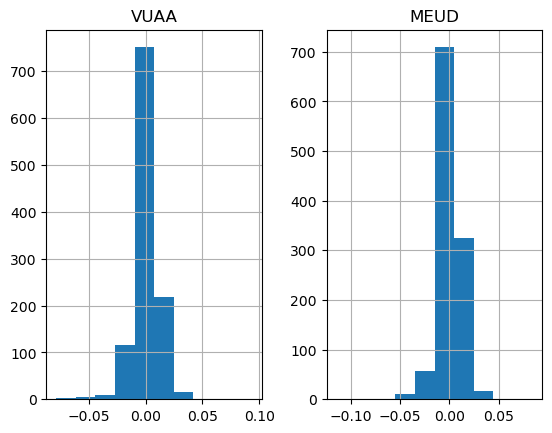

Skewness of VUAA is -0.473 which corresponds to a symmetric distribution.
Skewness of MEUD is -1.126 which corresponds to a highly negatively skewed distribution (investor desirable).
Skewness of VUAA is 8.948 which corresponds to a symmetric leptokutric distribution (fat-tailed, with majority returns in positive return extremum - Desirable).
Skewness of MEUD is 14.425 which corresponds to a negatively-skewed leptokutric distribution (fat-tailed, with majority returns in positive return extremum - Desirable).


In [10]:
plt.figure(figsize=(12, 8))
daily_return.hist()
plt.show()

print(f'Skewness of {daily_return.skew().index[0]} is {np.round(daily_return.skew()[0],3)} which corresponds to a symmetric distribution.')
print(f'Skewness of {daily_return.skew().index[1]} is {np.round(daily_return.skew()[1],3)} which corresponds to a highly negatively skewed distribution (investor desirable).')
print(f'Skewness of {daily_return.kurtosis().index[0]} is {np.round(daily_return.kurtosis()[0],3)} which corresponds to a symmetric leptokutric distribution (fat-tailed, with majority returns in positive return extremum - Desirable).')
print(f'Skewness of {daily_return.kurtosis().index[1]} is {np.round(daily_return.kurtosis()[1],3)} which corresponds to a negatively-skewed leptokutric distribution (fat-tailed, with majority returns in positive return extremum - Desirable).')

## Maximum Daily Drawdown 

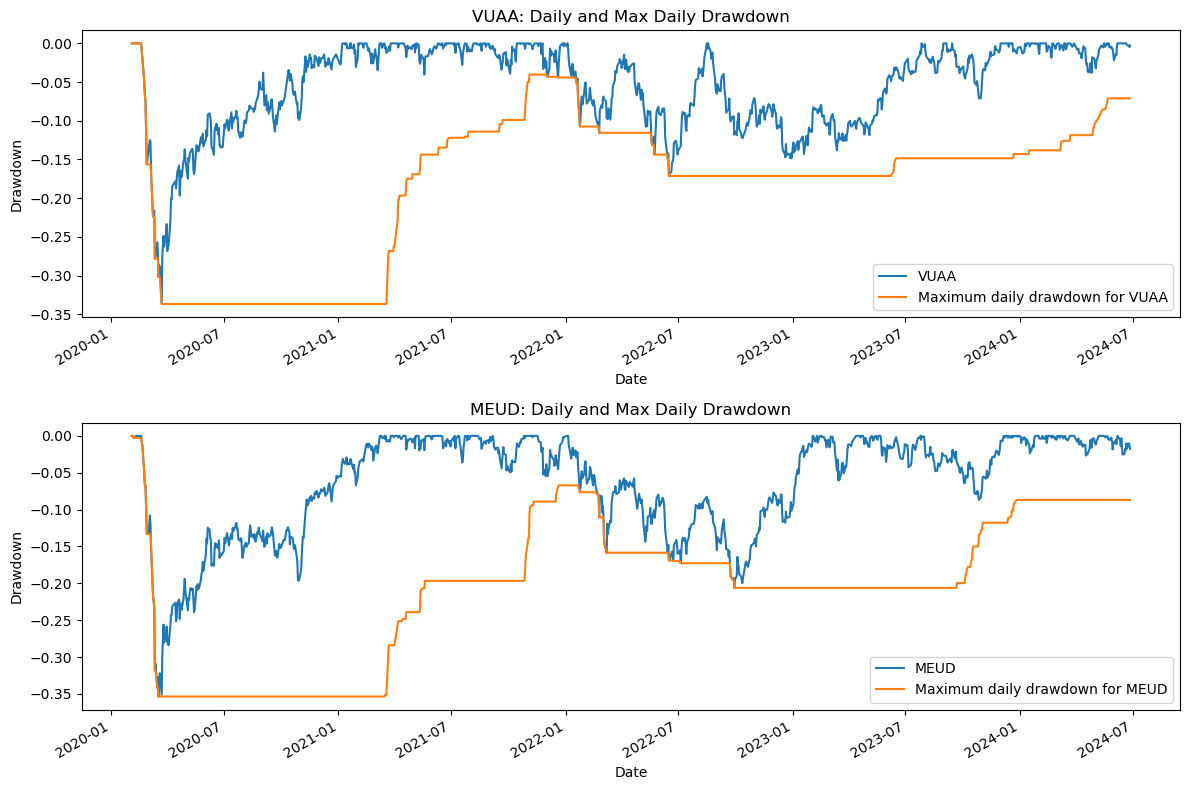

In [11]:
# Daily and maximum drawdowns for VUAA and MEUD
roll_max = etfs_hist_returns.rolling(min_periods=1, window = 252).max()
daily_drawdown = etfs_hist_returns/roll_max - 1
max_daily_drawdown = daily_drawdown.rolling(min_periods = 1, window = 252).min()

# VUAA drawdown
vuaa_drawdown = pd.concat([daily_drawdown.iloc[:,0], max_daily_drawdown.iloc[:,0]], axis=1)
vuaa_drawdown.columns = ['VUAA', 'Maximum daily drawdown for VUAA']

# MEUD drawdown
meud_drawdown = pd.concat([daily_drawdown.iloc[:,1], max_daily_drawdown.iloc[:,1]], axis=1)
meud_drawdown.columns = ['MEUD', 'Maximum daily drawdown for MEUD']

# Plotting results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Plot vuaa_drawdown on the first subplot
vuaa_drawdown.plot(ax=axes[0], title='VUAA: Daily and Max Daily Drawdown')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Drawdown')

# Plot meud_drawdown on the second subplot
meud_drawdown.plot(ax=axes[1], title='MEUD: Daily and Max Daily Drawdown')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown')

plt.tight_layout() 
plt.show()